- https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html#Loading-Visium-and-scRNA-seq-reference-data

# Creating an virtual environment    
1. ``micromamba create -n cell2loc python=3.10``
2. ``micromamba activate cell2loc``
3. ``python -m ipykernel install --user --name=cell2``
4. ``conda install scvi-tools``
5. ``conda install ipykernel``
6. ``pip install "git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]"``

In [1]:
import numpy as np
np.__version__

'2.1.3'

In [2]:
import cell2location
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42  

In [3]:
import os

# define analysis results
results_folder = "./cell2location_results/"

# os.makedirs(results_folder, exist_ok=True)

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f"{results_folder}/reference_signatures"
run_name = f"{results_folder}/cell2location_map"

# Loading Visium and scRNA-seq ref data

In [4]:
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")

# save first sample name in obs
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

# save gene name in var
adata_vis.var['SYMBOL'] = adata_vis.var_names

# set gene_ids to the new index.
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

/tmp/ipykernel_745672/1409868448.py:1: FutureWarning: Use `squidpy.datasets.visium` instead.
  adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
/home/s202155119/micromamba/envs/cell2/lib/python3.10/site-packages/scanpy/datasets/_datasets.py:558: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)


/home/s202155119/micromamba/envs/cell2/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/s202155119/micromamba/envs/cell2/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [6]:
# read data
adata_ref = sc.read(
    f'./data/sc.h5ad',
    backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad'
)

Rename genes to ENSEMBL ID for correct matching between single cell and spatial data.

In [7]:
# save adata_ref index
adata_ref.var['SYMBOL'] = adata_ref.var.index

# rename 'GeneID-2' as necessary for your data
adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

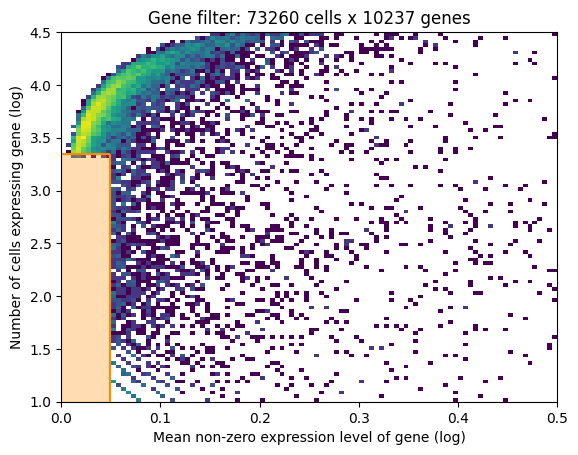

In [8]:
# 2D histogram
from cell2location.utils.filtering import filter_genes

selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_ref = adata_ref[:, selected].copy()

# Estimation of reference cell type signatures (NB regression)

In [9]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(
    adata=adata_ref,
    # 10X reaction / sample / batch
    # batch_key='dataset',
    # cell type, covariate used for constructing signatures
    labels_key="Subset",
    # multiplicative technical effects (platform, 3' vs 5', donor effect)
    categorical_covariate_keys=['Method']
)

In [10]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.2.post2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 73260 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  34   │
│          n_vars          │ 10237 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │    B_Cycling     │          0          │
│                     │     B_GC_DZ      │          1          │
│                     │     B_GC_LZ      │          2          │
│                     │    B_GC_prePB    │          3          │
│                     │      B_IFN       │          4          │
│                     │   B_activated    │          5          │
│                     │      B_mem       │          6          │
│                     │     B_naive      │          7          │
│                     │     B_plasma     │          8          │
│                     │     B_preGC      │          9          │
│                     │     DC_CCR7+     │         10          │
│                     │     DC_cDC1      │         11          │
│                     │     DC_cDC2      │         12          │
│                     │      DC_pDC      │         13          │
│                     │       Endo       │         14          │
│                     │       FDC        │         15          │
│                     │       ILC        │         16          │
│                     │  Macrophages_M1  │         17          │
│                     │  Macrophages_M2  │         18          │
│                     │       Mast       │         19          │
│                     │    Monocytes     │         20          │
│                     │        NK        │         21          │
│                     │       NKT        │         22          │
│                     │      T_CD4+      │         23          │
│                     │    T_CD4+_TfH    │         24          │
│                     │  T_CD4+_TfH_GC   │         25          │
│                     │   T_CD4+_naive   │         26          │
│                     │  T_CD8+_CD161+   │         27          │
│                     │ T_CD8+_cytotoxic │         28          │
│                     │   T_CD8+_naive   │         29          │
│                     │     T_TIM3+      │         30          │
│                     │      T_TfR       │         31          │
│                     │      T_Treg      │         32          │
│                     │       VSMC       │         33          │
└─────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
python -c "import torch; print(torch.cuda.is_available())"   # True 나오면 됨

In [ ]:
# training model with GPU
mod.train(max_epochs=250, accelerator="gpu")

# training model with CPU - takes a long time
# mod.train(max_epochs=250)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/khyeonmin/micromamba/envs/cell2/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/khyeonmin/micromamba/envs/cell2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `

Training:   0%|          | 0/250 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


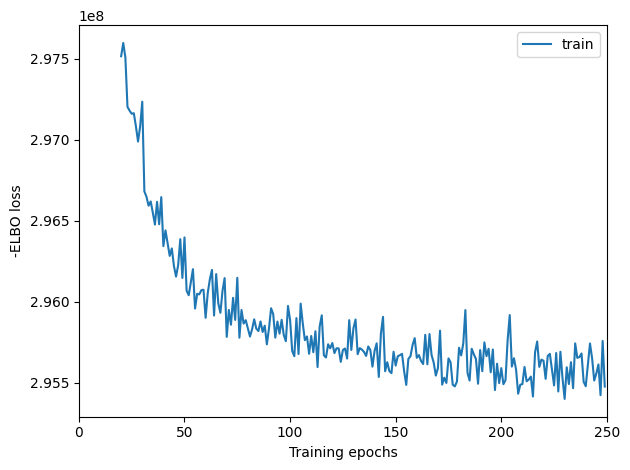

In [14]:
# plot ELBO loss history during training
mod.plot_history(20)

In [13]:
# export the estimated cell abundance
adata_ref = mod.export_posterior(adata_ref, sample_kwargs={"num_samples": 1000, "batch_size": 2500})

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling local variables, batch:   0%|          | 0/30 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

'./cell2location_results//reference_signatures/sc.h5ad'

In [14]:
adata_ref = mod.export_posterior(
    adata_ref,
    use_quantiles=True,
    sample_kwargs={"batch_size": 2500},
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling local variables, batch:   0%|          | 0/573 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

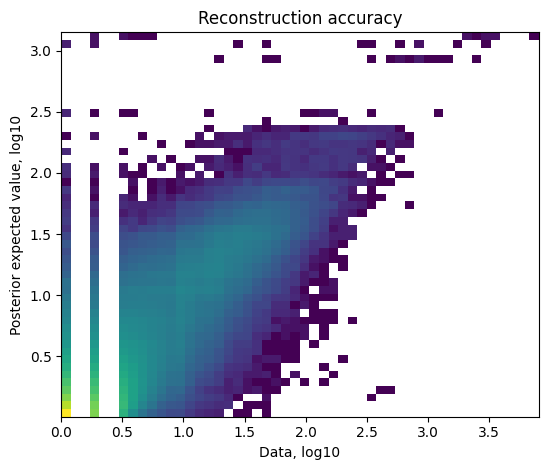

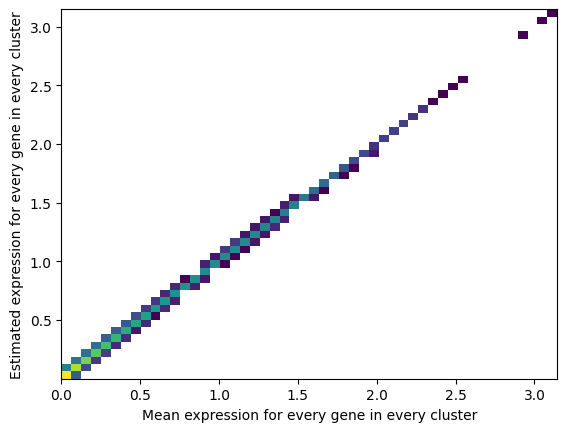

In [17]:
# QC plots
mod.export_posterior(adata_ref)
mod.plot_QC()

In [24]:
model_path = f"{ref_run_name}/model.pt"
model_path

'./cell2location_results//reference_signatures/model.pt'

In [28]:
# The model and output h5ad can be loaded later like this
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
# mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [31]:
model_path = "../dataset_final/reference_signatures"

mod = cell2location.models.RegressionModel.load(model_path, adata_ref)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ../dataset_final/reference_signatures/model.pt already downloaded                                    


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/s202155119/micromamba/envs/cell2/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Training:   0%|          | 0/273 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [32]:
# extract each gene expression level in each cluster
if "means_per_cluster_mu_fg" in adata_ref.varm.keys():
    inf_aver = adata_ref.varm["means_per_cluster_mu_fg"][
        [f"means_per_cluster_mu_fg_{i}" for i in adata_ref.uns["mod"]["factor_names"]]
    ].copy()
else:
    inf_aver = adata_ref.var[[f"means_per_cluster_mu_fg_{i}" for i in adata_ref.uns["mod"]["factor_names"]]].copy()
inf_aver.columns = adata_ref.uns["mod"]["factor_names"]
inf_aver.iloc[0:5, 0:5]

B_Cycling   B_GC_DZ   B_GC_LZ  B_GC_prePB     B_IFN
GeneID-2                                                            
ENSG00000188976   0.284919  0.181528  0.223717    0.272827  0.141480
ENSG00000188290   0.004739  0.000503  0.001320    0.013722  0.045482
ENSG00000187608   0.333812  0.225370  0.273310    0.476722  4.119150
ENSG00000186891   0.025652  0.002919  0.052695    0.040775  0.005158
ENSG00000186827   0.011302  0.000503  0.010467    0.013605  0.005148

# cell2location spatial mapping

In [33]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [34]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [35]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis,
    cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20,
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.2.post2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4035  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 10217 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                       batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V1_Human_Lymph_Node │          0          │
└─────────────────────┴─────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

Training cell2location : It takes a lot of time!!

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/khyeonmin/micromamba/envs/cell2/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/khyeonmin/micromamba/envs/cell2/lib/python3.10/site-packages/lightn

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30000` reached.


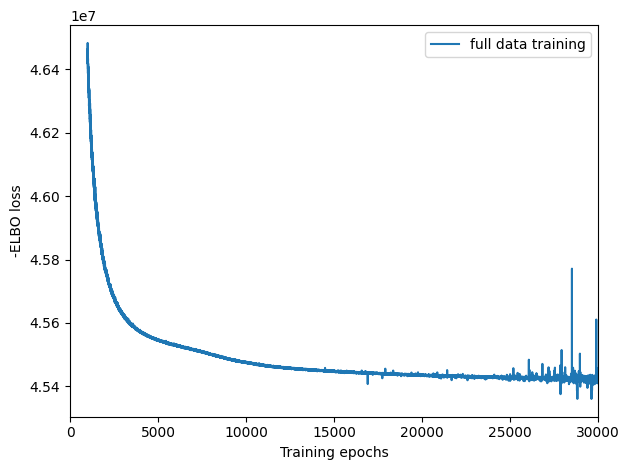

In [23]:
mod.train(
    max_epochs=30000,
    # train using full data (batch_size=None)
    batch_size=None,
    # use all data points in training because
    # we need to estimate cell abundance at all locations
    train_size=1,
    accelerator="gpu",
)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=["full data training"]);

In [24]:
# export the estimated cell abundance (summary of the posterior distribution).
adata_vis  = mod.export_posterior(
    adata_vis , sample_kwargs={"num_samples": 1000, "batch_size": mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling local variables, batch:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ./cell2location_results//cell2location_map/model.pt already downloaded                               


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/khyeonmin/micromamba/envs/cell2/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/khyeonmin/micromamba/envs/cell2/lib/python3.10/site-packages/lightn

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


'./cell2location_results//cell2location_map/sp.h5ad'

# Visualising cell abundance in spatial coordinates

- **The mod learning process takes a lot of time, so load the saved model and run it.**

In [43]:
# adata_file = f"{run_name}/sp.h5ad"
adata_file = "../dataset_final/cell2location_map/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)
mod = cell2location.models.Cell2location.load("../dataset_final/cell2location_map", adata_vis)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ../dataset_final/cell2location_map/model.pt already downloaded                                       


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/s202155119/micromamba/envs/cell2/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/s202155119/micromamba/envs/cell2/lib/python3.10/site-packages/ligh

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [44]:
print("adata_vis.obsm 키 목록:", list(adata_vis.obsm.keys()))

adata_vis.obsm 키 목록: ['MT', 'X_umap', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf']


In [45]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns["mod"]["factor_names"]] = adata_vis.obsm["q05_cell_abundance_w_sf"]

/tmp/ipykernel_745672/3704815930.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(slide, cmap='magma',


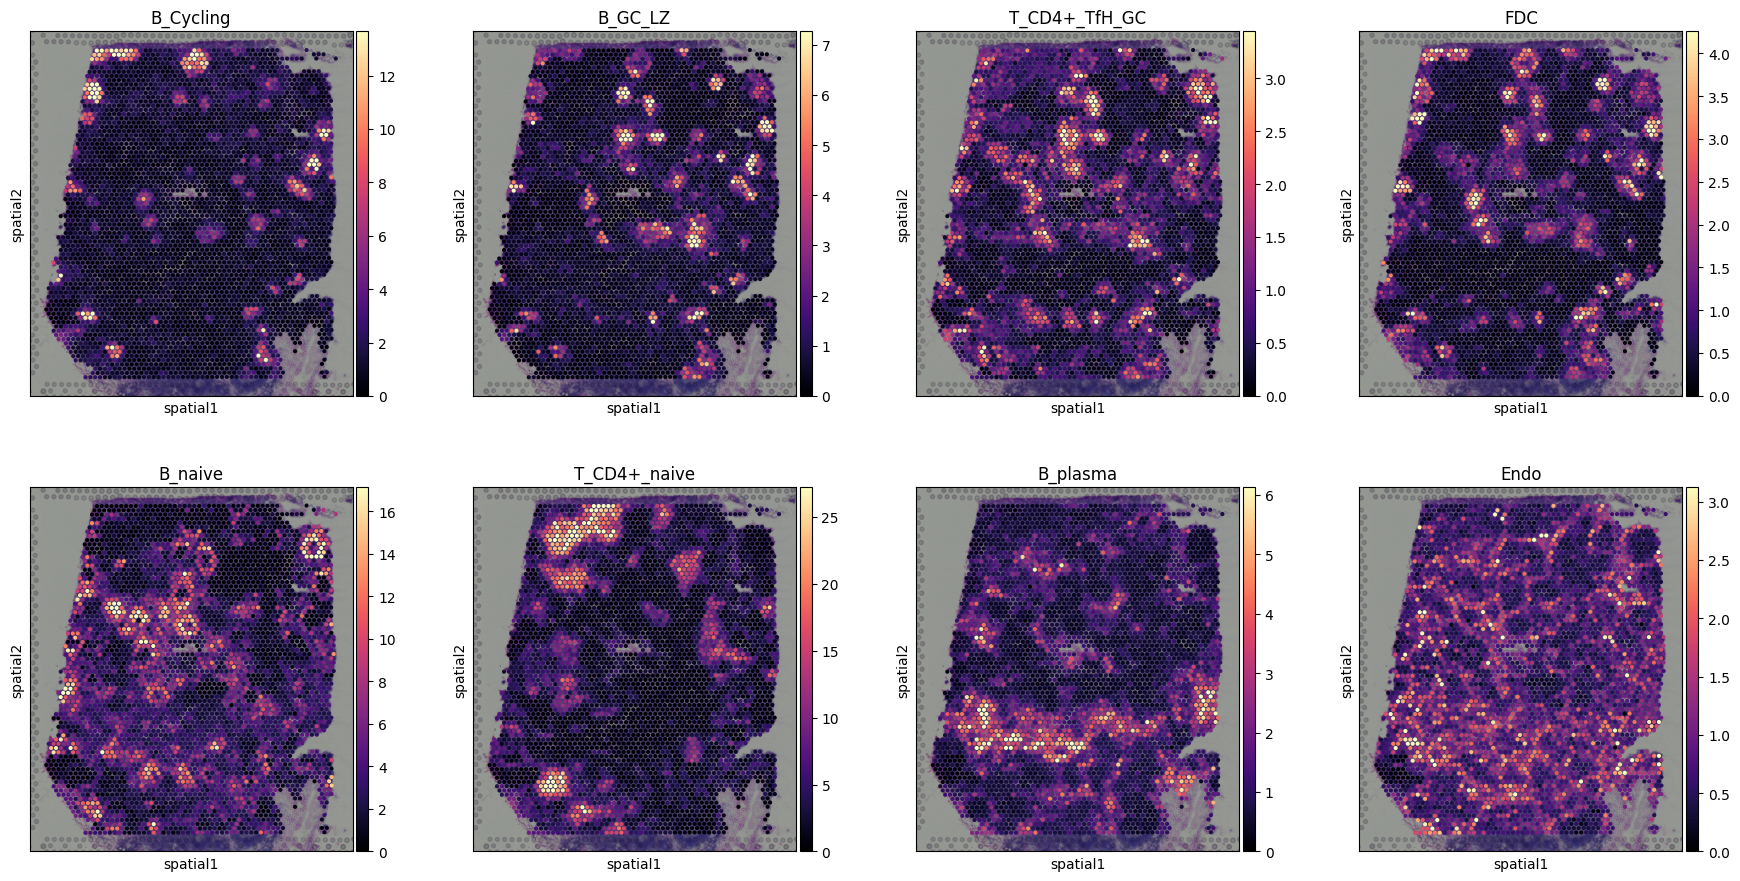

In [46]:
from cell2location.plt import plot_spatial

from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                         'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )



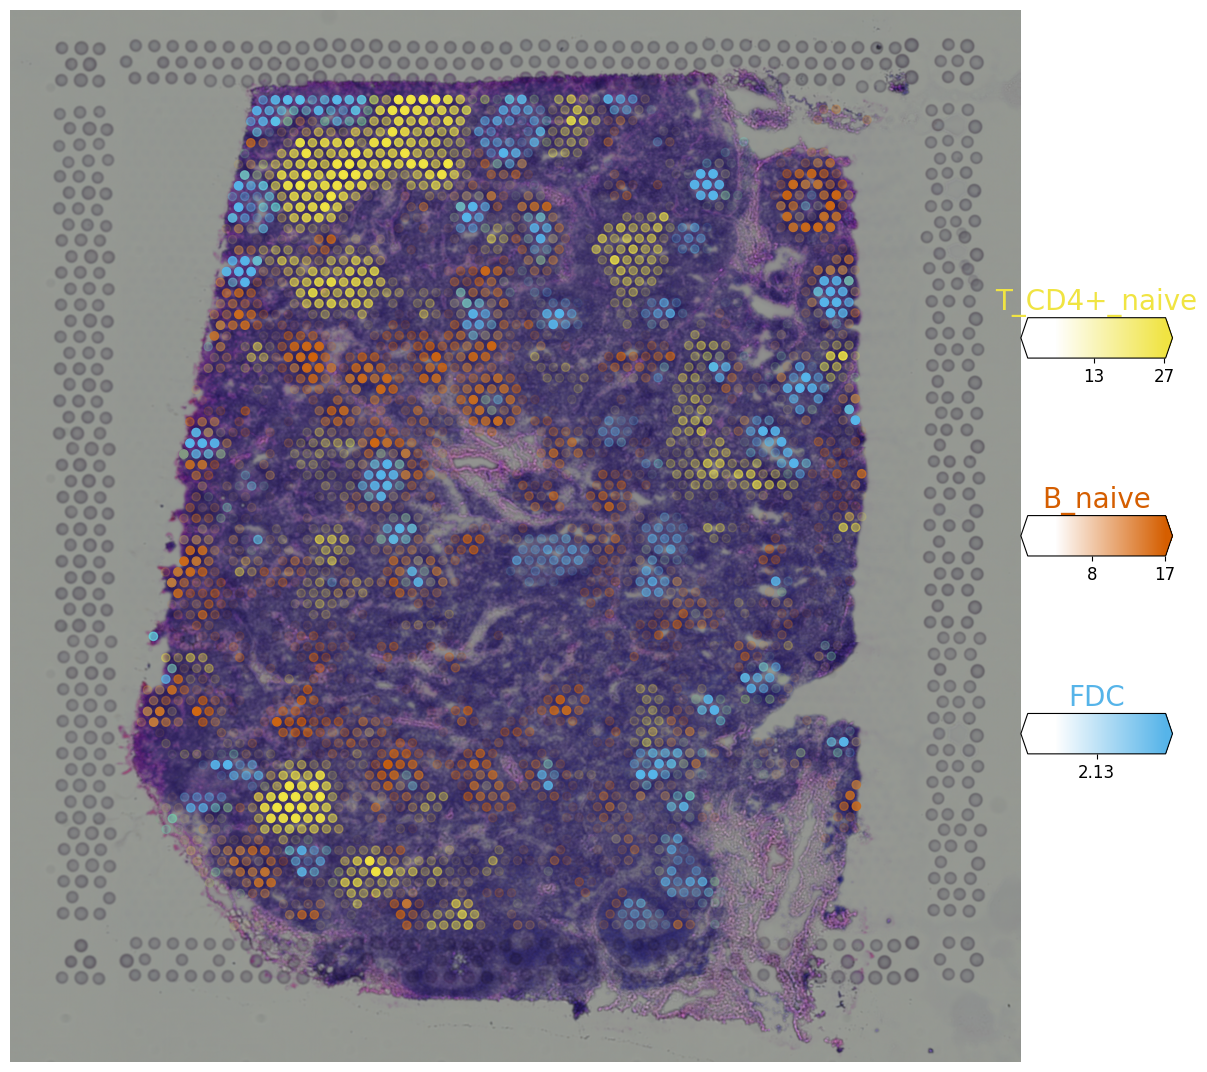

In [47]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['T_CD4+_naive', 'B_naive', 'FDC']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

# Downstream analysis
### Identifying discrete tissue regions by Leiden clustering

In [48]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

/tmp/ipykernel_745672/23575634.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_vis, resolution=1.1)


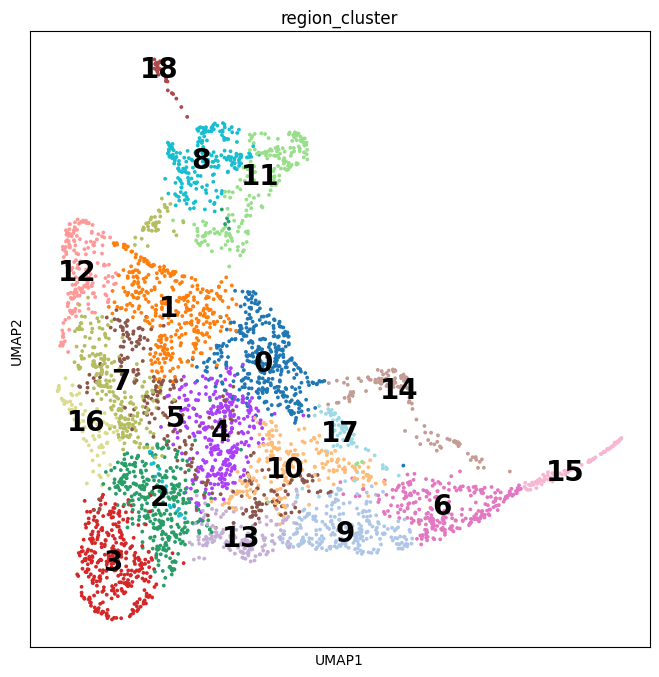

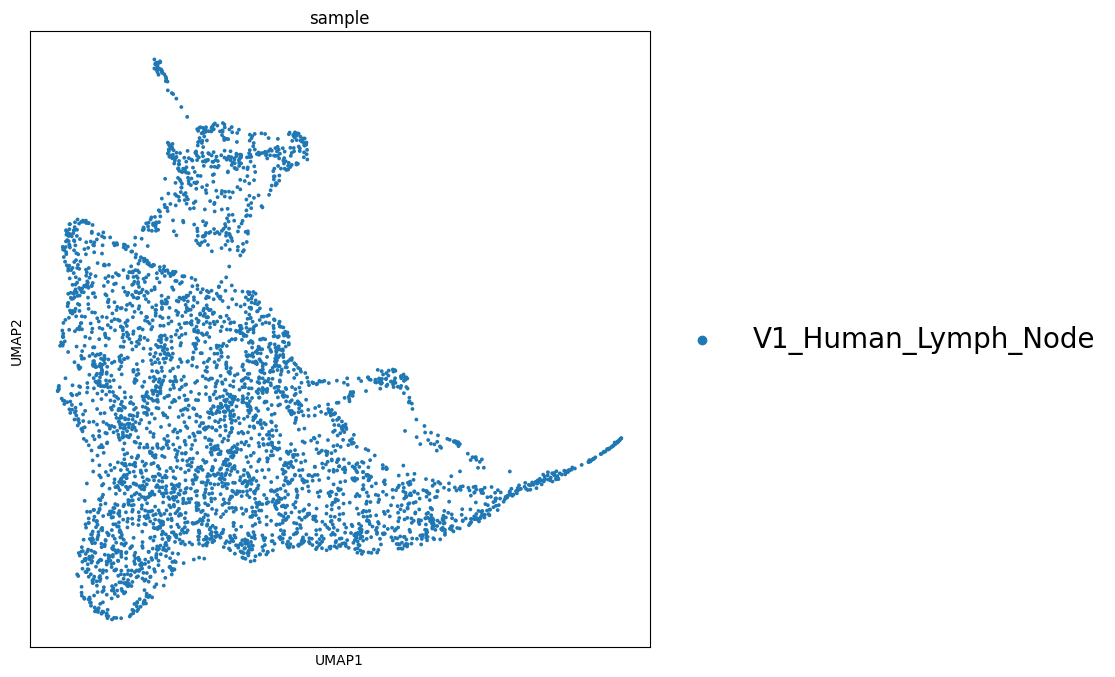

/tmp/ipykernel_745672/3691370081.py:17: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_vis, color=['region_cluster'],


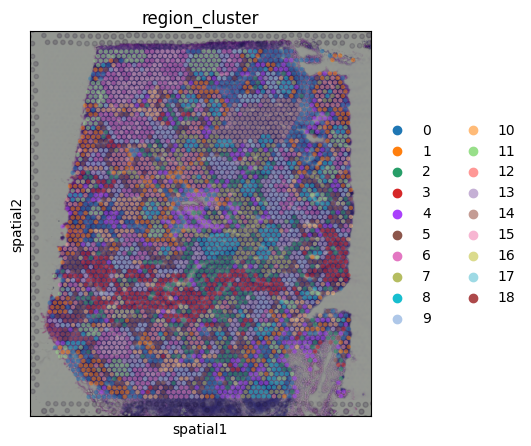

In [49]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

### Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

In [50]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4035locations_34factors


/home/s202155119/micromamba/envs/cell2/lib/python3.10/site-packages/cell2location/run_colocation.py:384: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_4035locations_34factors


/home/s202155119/micromamba/envs/cell2/lib/python3.10/site-packages/cell2location/run_colocation.py:384: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


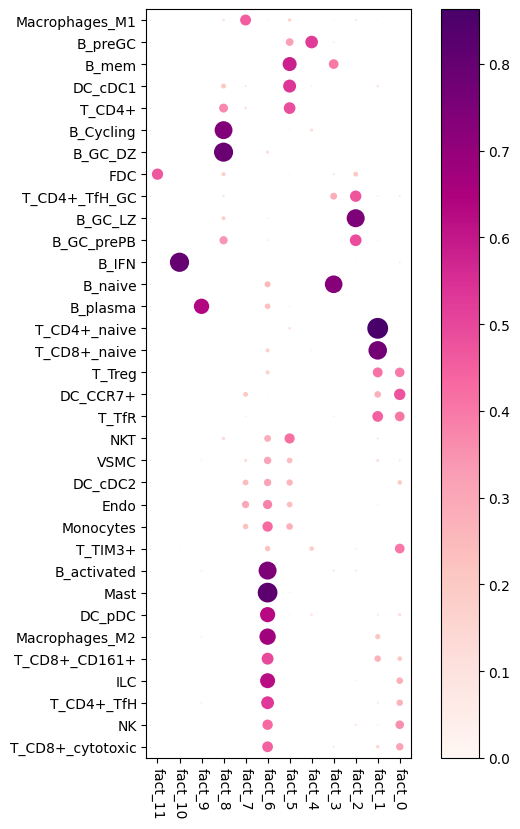

In [51]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

### Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM)

In [52]:
print(dir(mod))

['_OBSERVED_LIB_SIZE_KEY', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_adata', '_adata_manager', '_check_if_trained', '_create_modalities_attr_dict', '_data_loader_cls', '_data_splitter_cls', '_export2adata', '_get_init_params', '_get_most_recent_anndata_manager', '_get_obs_plate_return_sites', '_get_obs_plate_sites', '_get_one_posterior_sample', '_get_posterior_samples', '_get_setup_method_args', '_get_user_attributes', '_make_data_loader', '_model_summary_string', '_module_init_on_train', '_optim_param', '_per_instance_manager_store', '_posterior_quantile', '_posterior_quantile_minibatch', '_posterior_samples_minibatch', '_register_manager_for_instance

In [53]:
posterior_samples = mod.sample_posterior()
print(posterior_samples.keys())

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling local variables, batch:   0%|          | 0/32 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

dict_keys(['post_sample_means', 'post_sample_stds', 'post_sample_q05', 'post_sample_q95'])


In [54]:
q05_samples = posterior_samples['post_sample_q05']

# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    q05_samples, mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'./cell2location_results//cell2location_map/sp.h5ad'

In [55]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

def plot_genes_per_cell_type(slide, genes, ctypes):
    n_genes = len(genes)
    n_ctypes = len(ctypes)
    fig, axs = plt.subplots(
        nrows=n_genes, ncols=n_ctypes + 1, figsize=(4.5 * (n_ctypes + 1) + 2, 5 * n_genes + 1), squeeze=False
    )
    
    for j in range(n_genes):
        gene_condition = np.in1d(slide.var["SYMBOL"], genes[j])
        quantile_across_ct = np.array(
            [
                np.quantile(slide.layers[n][:, gene_condition].toarray(), 0.992)
                for n in slide.uns["mod"]["factor_names"]
            ]
        )
        quantile_across_ct = np.partition(quantile_across_ct.flatten(), -2)[-2]
        
        sc.pl.spatial(
            slide,
            cmap="magma",
            color=genes[j],
            gene_symbols="SYMBOL",
            ncols=4,
            size=1.3,
            img_key="hires",
            vmin=0,
            vmax="p99.2",
            ax=axs[j, 0],
            show=False,
        )

        for i in range(n_ctypes):
            sc.pl.spatial(
                slide,
                cmap="magma",
                color=genes[j],
                layer=ctypes[i],
                gene_symbols="SYMBOL",
                ncols=4,
                size=1.3,
                img_key="hires",
                vmin=0,
                vmax=quantile_across_ct,
                ax=axs[j, i + 1],
                show=False,  
            )
            axs[j, i + 1].set_title(f"{genes[j]} {ctypes[i]}")
    
    plt.show()
    return fig, axs


/tmp/ipykernel_745672/375001806.py:13: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  gene_condition = np.in1d(slide.var["SYMBOL"], genes[j])
/tmp/ipykernel_745672/375001806.py:22: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(
/tmp/ipykernel_745672/375001806.py:37: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


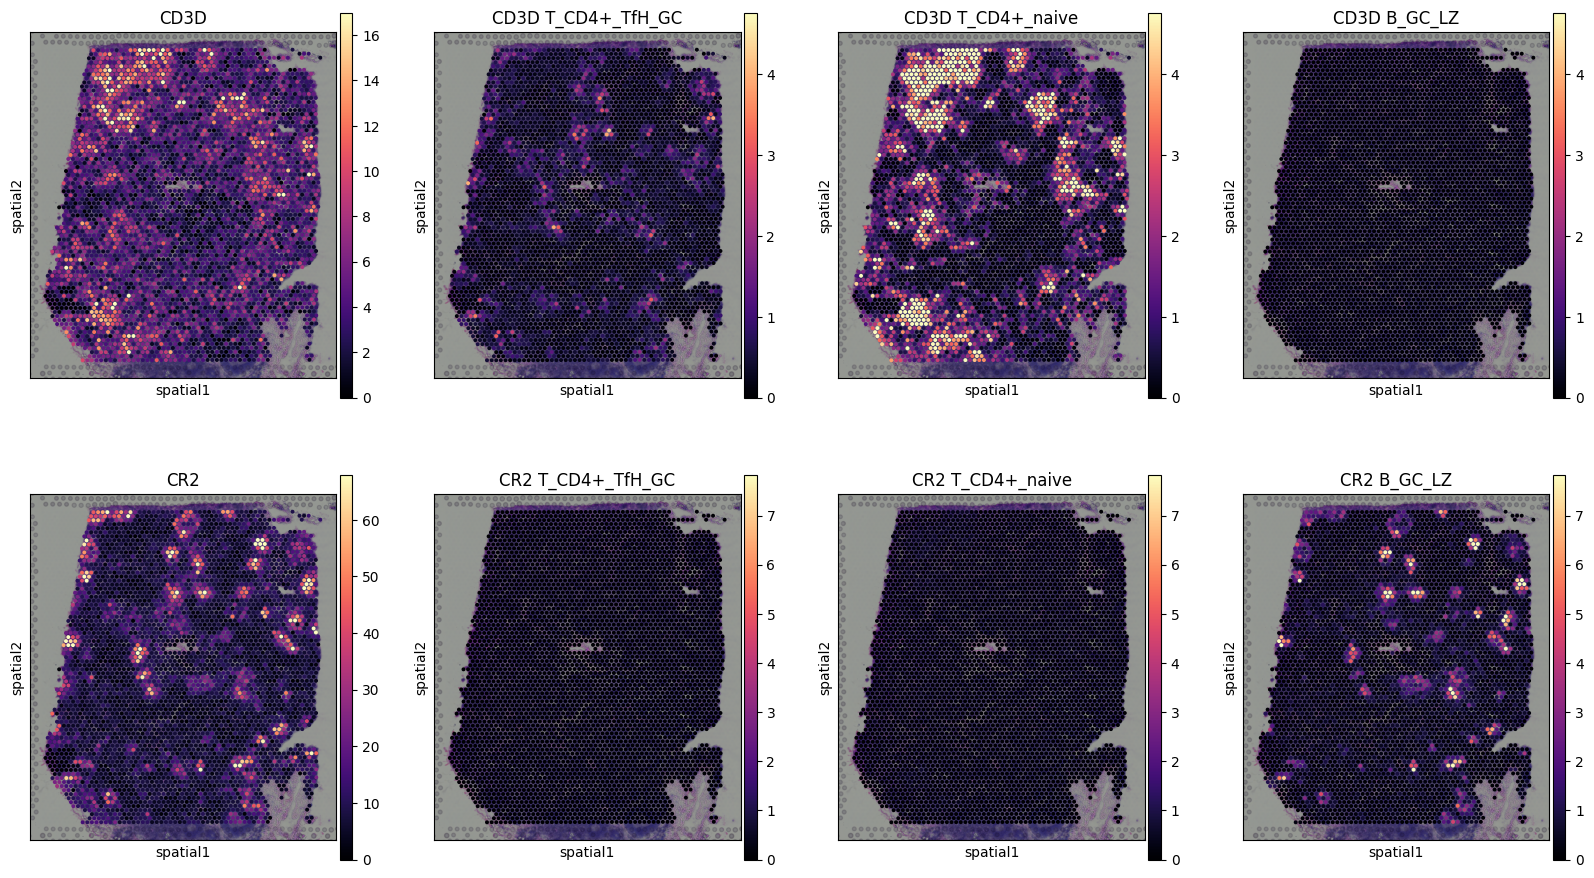

In [56]:
# list cell types and genes for plotting
ctypes = ['T_CD4+_TfH_GC', 'T_CD4+_naive', 'B_GC_LZ']
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

    # from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes)